# CNN_3channel_moredata

Abstract:
- Conv的kernel_size有(1, 1)和(2, 2)
- single channel: band_avg
- CNN, small net

Result:
- Kaggle score: 

References:
- https://www.kaggle.com/ivalmian/simple-svd-xgboost-baseline-lb-35
- https://www.kaggle.com/arieltci/a-keras-prototype-0-21174-on-pl

## 1. Preprocess

### Import pkgs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import log_loss, accuracy_score
from IPython.display import display

%matplotlib inline

In [2]:
import os
import time
import zipfile
import lzma
import pickle
from PIL import Image
from shutil import copy2
import gc

import cv2

### Run name

In [3]:
project_name = 'SC_Iceberg_Classifier'
step_name = 'CNN_3channel_moredata'
date_str = time.strftime("%Y%m%d", time.localtime())
time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime())
run_name = project_name + '_' + step_name + '_' + time_str
print('run_name: ' + run_name)
t0 = time.time()

run_name: SC_Iceberg_Classifier_CNN_3channel_moredata_20180106_133219


### Basic folders

In [4]:
cwd = os.getcwd()
input_path = os.path.join(cwd, 'input')
log_path = os.path.join(cwd, 'log')
model_path = os.path.join(cwd, 'model')
output_path = os.path.join(cwd, 'output')
print('input_path: ' + input_path)
print('log_path: ' + log_path)
print('model_path: ' + model_path)
print('output_path: ' + output_path)

input_path: /data1/Kaggle/statoil-iceberg-classifier-challenge/input
log_path: /data1/Kaggle/statoil-iceberg-classifier-challenge/log
model_path: /data1/Kaggle/statoil-iceberg-classifier-challenge/model
output_path: /data1/Kaggle/statoil-iceberg-classifier-challenge/output


### Basic functions

In [5]:
import sys
def describe(arr):
    print(arr.shape, arr.min(), arr.max(), sys.getsizeof(arr))

### Load data

In [6]:
sample_submission_path = os.path.join(input_path, 'sample_submission.csv')
sample_submission = pd.read_csv(sample_submission_path)
print(sample_submission.shape)
sample_submission.head(2)

(8424, 2)


,id,is_iceberg
0,5941774d,0.5
1,4023181e,0.5


In [7]:
is_iceberg_path = os.path.join(input_path, 'is_iceberg.p')

y_data = pickle.load(open(is_iceberg_path, mode='rb'))

describe(y_data)

(1604,) 0 1 25688


In [8]:
%%time
#Load orignal data
inc_angle_data_path = os.path.join(input_path, 'inc_angle_data.p')
inc_angle_test_path = os.path.join(input_path, 'inc_angle_test.p')

inc_angle_data = pickle.load(open(inc_angle_data_path, mode='rb'))
inc_angle_test = pickle.load(open(inc_angle_test_path, mode='rb'))

print(inc_angle_data.shape)
print(inc_angle_test.shape)

(1604,)
(8424,)
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.17 ms


In [9]:
%%time
#Load orignal data
band1_data_path = os.path.join(input_path, 'band1_data.p')
band2_data_path = os.path.join(input_path, 'band2_data.p')
band1_test_path = os.path.join(input_path, 'band1_test.p')
band2_test_path = os.path.join(input_path, 'band2_test.p')

band1_data = pickle.load(open(band1_data_path, mode='rb'))
band2_data = pickle.load(open(band2_data_path, mode='rb'))
band1_test = pickle.load(open(band1_test_path, mode='rb'))
band2_test = pickle.load(open(band2_test_path, mode='rb'))

band_avg_data = (band1_data + band2_data)/2
band_avg_test = (band1_test + band2_test)/2

describe(band1_data)
describe(band2_data)
describe(band1_test)
describe(band2_test)

describe(band_avg_data)
describe(band_avg_test)

(1604, 75, 75) -45.594448 34.574917 128
(1604, 75, 75) -45.655499 20.154249 128
(8424, 75, 75) -45.6805458069 37.090523 128
(8424, 75, 75) -49.0835 37.0905227661 128
(1604, 75, 75) -39.1164895 27.364583 72180128
(8424, 75, 75) -43.3067741394 35.3033447266 379080128
CPU times: user 620 ms, sys: 988 ms, total: 1.61 s
Wall time: 1.6 s


In [10]:
%%time
x_data = np.concatenate([band1_data[:, :, :, np.newaxis],
                         band2_data[:, :, :, np.newaxis],
                         band_avg_data[:, :, :, np.newaxis]], axis=-1)
describe(x_data)
# del band1_data
# del band2_data
# del band_avg_data
gc.collect()

x_test = np.concatenate([band1_test[:, :, :, np.newaxis],
                         band2_test[:, :, :, np.newaxis],
                         band_avg_test[:, :, :, np.newaxis]], axis=-1)
describe(x_test)
# del band1_test
# del band2_test
# del band_avg_test
gc.collect()

(1604, 75, 75, 3) -45.655499 34.574917 216540144
(8424, 75, 75, 3) -49.0835 37.090523 1137240144
CPU times: user 868 ms, sys: 412 ms, total: 1.28 s
Wall time: 1.28 s


In [11]:
%%time
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=31)

describe(x_train)
describe(x_val)

describe(y_train)
describe(y_val)

(1443, 75, 75, 3) -45.655499 34.574917 194805144
(161, 75, 75, 3) -43.190331 25.566628 21735144
(1443,) 0 1 23112
(161,) 0 1 2600
CPU times: user 88 ms, sys: 68 ms, total: 156 ms
Wall time: 154 ms


## 2. Build model

In [12]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization, Input
from keras.layers.merge import Concatenate
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, TensorBoard

Using TensorFlow backend.


In [13]:
def build_model():
    model = Sequential()

    model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu',
                     input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(strides=(2,2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(strides=(2,2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(strides=(2,2)))
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(units = 1, activation = 'sigmoid'))

    model.compile(optimizer = Adam(lr=1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [14]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 73, 73, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 73, 73, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 71, 71, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 35, 35, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        18496     
__________

In [15]:
def saveModel(model, run_name):
    cwd = os.getcwd()
    modelPath = os.path.join(cwd, 'model')
    if not os.path.isdir(modelPath):
        os.mkdir(modelPath)
    weigthsFile = os.path.join(modelPath, run_name + '.h5')
    model.save(weigthsFile)
# saveModel(model, 'saveModel_test')

In [16]:
def get_lr(x):
    lr = round(1e-4 * 0.99 ** x, 6)
    if lr < 5e-5:
        lr = 5e-5
    print(lr, end='  ')
    return lr

# annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
annealer = LearningRateScheduler(get_lr)

log_dir = os.path.join(log_path, run_name)
print('log_dir:' + log_dir)
tensorBoard = TensorBoard(log_dir=log_dir)

log_dir:/data1/Kaggle/statoil-iceberg-classifier-challenge/log/SC_Iceberg_Classifier_CNN_3channel_moredata_20180106_133219


In [17]:
# datagen = ImageDataGenerator(
#     rotation_range=10,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=True
# )

# datagen = ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=True,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True)

In [18]:
# %%time
# batch_size = 32
# steps_per_epoch = 1 * len(x_train) / batch_size
# hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size, shuffle = False),
#                            steps_per_epoch=100, 
#                            epochs = 50, #1 for ETA, 0 for silent
#                            verbose= 1,
#                            max_queue_size= 64, 
#                            workers= 8,
#                            validation_data=(x_val, y_val))

In [19]:
%%time
hist = model.fit(x_train, y_train, 
                 batch_size = 32, 
                 verbose= 1,
#                  callbacks = [annealer],
                 epochs = 100, #1 for ETA, 0 for silent
                 validation_data=(x_val, y_val))

Train on 1443 samples, validate on 161 samples
Epoch 1/100
1443/1443 [==============================] - 8s 6ms/step - loss: 0.9253 - acc: 0.5800 - val_loss: 0.6901 - val_acc: 0.5466
Epoch 2/100
1443/1443 [==============================] - 4s 3ms/step - loss: 0.6605 - acc: 0.6396 - val_loss: 0.7010 - val_acc: 0.4969
Epoch 3/100
1443/1443 [==============================] - 4s 3ms/step - loss: 0.6248 - acc: 0.6750 - val_loss: 0.7008 - val_acc: 0.4596
Epoch 4/100
1443/1443 [==============================] - 4s 3ms/step - loss: 0.5871 - acc: 0.6826 - val_loss: 0.7119 - val_acc: 0.4534
Epoch 5/100
1443/1443 [==============================] - 4s 3ms/step - loss: 0.5720 - acc: 0.6985 - val_loss: 0.7200 - val_acc: 0.4658
Epoch 6/100
1443/1443 [==============================] - 4s 3ms/step - loss: 0.5412 - acc: 0.7193 - val_loss: 0.7138 - val_acc: 0.4658
Epoch 7/100
1443/1443 [==============================] - 4s 3ms/step - loss: 0.5321 - acc: 0.7325 - val_loss: 0.6977 - val_acc: 0.4907
Epoch 8/

Epoch 61/100
1443/1443 [==============================] - 4s 3ms/step - loss: 0.1887 - acc: 0.9196 - val_loss: 0.4017 - val_acc: 0.8323
Epoch 62/100
1443/1443 [==============================] - 4s 3ms/step - loss: 0.2055 - acc: 0.9085 - val_loss: 0.4026 - val_acc: 0.8820
Epoch 63/100
1443/1443 [==============================] - 4s 3ms/step - loss: 0.1985 - acc: 0.9148 - val_loss: 0.3796 - val_acc: 0.8758
Epoch 64/100
1443/1443 [==============================] - 4s 3ms/step - loss: 0.1974 - acc: 0.9196 - val_loss: 0.3516 - val_acc: 0.8882
Epoch 65/100
1443/1443 [==============================] - 4s 3ms/step - loss: 0.2019 - acc: 0.9092 - val_loss: 0.3721 - val_acc: 0.8696
Epoch 66/100
1443/1443 [==============================] - 4s 3ms/step - loss: 0.1822 - acc: 0.9224 - val_loss: 0.4169 - val_acc: 0.8571
Epoch 67/100
1443/1443 [==============================] - 4s 3ms/step - loss: 0.1955 - acc: 0.9175 - val_loss: 0.4346 - val_acc: 0.8571
Epoch 68/100
1443/1443 [========================

In [20]:
final_loss, final_acc = model.evaluate(x_val, y_val, verbose=1)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

161/161 [==============================] - 0s 727us/step
Final loss: 0.7569, final accuracy: 0.7826


In [21]:
val_prob1 = model.predict(x_val)

# print('Val log_loss: {}'.format(log_loss(y_val, val_prob1)))
val_prob1_limit = np.clip(val_prob1, 0.00005, 0.99995)
loss = log_loss(y_val, val_prob1_limit)
print('Val log_loss: {}'.format(loss))

val_prob1_limit = np.clip(val_prob1_limit, 0.05, 0.95)
loss = log_loss(y_val, val_prob1_limit)
print('Val log_loss: {}'.format(loss))

Val log_loss: 0.7373132653558726
Val log_loss: 0.5120202262671838


In [22]:
final_acc_str = str(int(loss*10000))
run_name_acc = project_name + '_' + step_name + '_' + time_str + '_' + final_acc_str
print(run_name_acc)

SC_Iceberg_Classifier_CNN_3channel_moredata_20180106_133219_5120


In [23]:
histories = pd.DataFrame(hist.history)
histories['epoch'] = hist.epoch
print(histories.columns)
histories_file = os.path.join(model_path, run_name_acc + '.csv')
histories.to_csv(histories_file, index=False)

Index(['acc', 'loss', 'val_acc', 'val_loss', 'epoch'], dtype='object')


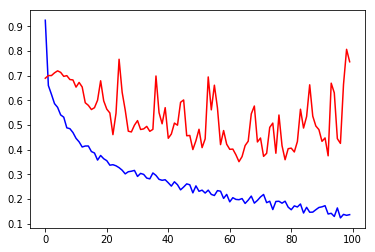

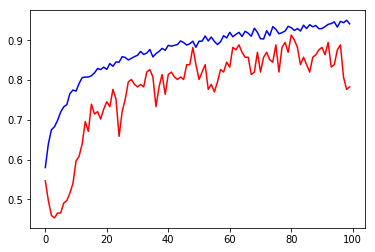

In [24]:
plt.plot(histories['loss'], color='b')
plt.plot(histories['val_loss'], color='r')
plt.show()
plt.plot(histories['acc'], color='b')
plt.plot(histories['val_acc'], color='r')
plt.show()

In [25]:
saveModel(model, run_name_acc)

## 3. Predict

In [26]:
if not os.path.exists(output_path):
    os.mkdir(output_path)
pred_file = os.path.join(output_path, run_name_acc + '.csv')
print(pred_file)

/data1/Kaggle/statoil-iceberg-classifier-challenge/output/SC_Iceberg_Classifier_CNN_3channel_moredata_20180106_133219_5120.csv


In [27]:
test_prob = model.predict(x_test)
print(test_prob.shape)
print(test_prob[0:2])
test_prob = np.clip(test_prob, 0.05, 0.95)
print(test_prob.shape)
print(test_prob[0:2])

(8424, 1)
[[  4.18339390e-04]
 [  9.48349118e-01]]
(8424, 1)
[[ 0.05      ]
 [ 0.94834912]]


In [28]:
sample_submission['is_iceberg'] = test_prob
print(sample_submission[0:2])
print(sample_submission.shape)
sample_submission.to_csv(pred_file, index=False)

         id  is_iceberg
0  5941774d    0.050000
1  4023181e    0.948349
(8424, 2)


In [29]:
t1 = time.time()
print('time cost: %.2f s' % (t1-t0))
print('Done!')

time cost: 397.58 s
Done!


In [30]:
print(run_name_acc)

SC_Iceberg_Classifier_CNN_3channel_moredata_20180106_133219_5120
